## <center> Working with the NOMAD archive </center>

In this part of the tutorial we will demonstrate how to query data from the NOMAD repo and work with it within a Python environment.

As an example, we will use a short simulation of an atomistic box of hexane molecules.

Import all the necessary modules. If you want to skip the molecular visualization, comment out nglview

In [1]:
# conda create -n "CECAM_tutorial" python==3.9
# conda activate CECAM_tutorial
# pip install nomad-lab
# conda install nglview
# conda install "ipywidgets <8" -c conda-forge

# NOTE: you may have to restart vscode or other editor after running these updates.

In [2]:
# Python
import numpy as np

# NOMAD tools
from nomad.atomutils import archive_to_universe
from nomad.atomutils import BeadGroup
from nomad.datamodel import EntryArchive
from nomad.units import ureg

# I/O
import json

# Visualization
import matplotlib.pyplot as plt
import nglview as nv
print(nv.__version__)

# MDAnalysis
import MDAnalysis.analysis.rdf as MDA_RDF
from MDAnalysis.analysis.distances import self_distance_array

import requests
import time as t

3.0.8


In general, you can use the [NOMAD Application Programming Interface (API)](https://nomad-lab.eu/prod/rae/docs/api.html) to
- upload data, especially useful when you are producing data via a workflow.
- delete data.
- query all kinds of (meta)data: processed (from the archive), raw (from the repository), large bundles, individual entries, etc.

Each functionality has its own url, i.e. _endpoints_. There are over 60 different endpoints, each specialized in their own little subtask. You can find the full overview over at the [API dashboard](https://nomad-lab.eu/prod/v1/staging/api/v1/extensions/docs#/). It is highly recommended to have this page open when writing queries. Lastly, you can also use the dashboard to try out queries on the fly.

In this first exercise, we will download the **processed molecular dynamics trajectory** of an **individual entry** to perform our own visualization and analysis.
For this, we will be using the `/entries/{entry_id}`/archive. The `{entry_id}` here is variable, which you can get from the NOMAD website (or other API queries). Note that there are 3 versions of this endpoint: one that only gives you the metadata, one that returns the entire archive (`/download`), and a last wildcard that we will get into later (`/query`). Here is are 2 methods: one to nicely format the endpoint and the other to time the download time. 

In [3]:
nomad_api_prefix = 'https://nomad-lab.eu/prod/v1/api/v1/'

def nomad_individual_archive_url(entry_id: str, endpoint_type: str=''):
    '''Produces the endpoint URL for downloading a NOMAD individual archive.
    `entry_id` specifies the entry ID of the particular archive you want to download.
    Use `endpoint_type` to further specify the particular subtype (`download` or `query`).'''

    endpoint_specifications = ('download', 'query')
    endpoint = f'{nomad_api_prefix}/entries/{entry_id}/archive'

    if endpoint_type :
        if endpoint_type in endpoint_specifications:
            endpoint += f'/{endpoint_type}'
        else:
            raise ValueError(f'endpoint_type must be one of {endpoint_specifications}')
    return endpoint

In [4]:
def measure_method(method, *args, **kwargs):
    """
    Measure the execution time of a given method with arguments.
    
    Args:
        method: The method/function to be measured.
        *args: Positional arguments to be passed to the method.
        **kwargs: Keyword arguments to be passed to the method.
    """
    start_time = t.time()
    result = method(*args, **kwargs)
    end_time = t.time()
    elapsed_time = end_time - start_time
    
    elapsed_minutes = int(elapsed_time // 60)
    elapsed_seconds = int(elapsed_time % 60)
    
    print(f"Method took {elapsed_minutes} minutes and {elapsed_seconds} seconds to execute.")
    return result

Now let us try it out! Run the cell below. Note that it may easily take up to 5 minutes or more, depending on your Internet's bandwidth. Meanwhile, we will walk you through what is going on and the expected output.

Python provides a module for packaging and sending requests, aptly named `requests`. It comes with the methods `put`, `delete`, `get`, and `post`. Notice how the API dashboard lists each supported function next to its endpoint. The first 3 exactly serve the functionalities that we listed abovee (upload, delete, download). The last one, `post`, we will get into later.

The formatted URL itself actually suffices to start the download. It just needs an interface. If you click on it (don't, it's just a hypothetical), your OS should open a browser to start the download. From the command line, you can use `curl`. The `requests` module is simply our Python interface. As with any https protocol, you will receive a [status code](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status). Additional information is transmitted in a JSON format (another web standard), which we deserialize to a dictionary here. When everything is successful, this contains the data we were looking for. In case of an error, the NOMAD API uses it to better articulate the reason under the keyword `detail`. For the full format we again refer the reader to the API dashboard.

In [5]:
# execute the download
nomad_url = nomad_individual_archive_url('hxaepf6x12Xt2IX2jCt4DyfLG0P4', endpoint_type='download')
response = measure_method(requests.get, nomad_url)
data = response.json()

# print some of the responses
print(f'This is the endpoint URL: {nomad_url}. Click on it start downloading the archive via your browser.')
print(f"This is the {response} message. In case of an error, check `response['detail']` to get the additional information.")
print(f"This is the top-level data structure of the deserialized message: {data.keys()}")

Method took 8 minutes and 23 seconds to execute.
This is the endpoint URL: https://nomad-lab.eu/prod/v1/api/v1//entries/hxaepf6x12Xt2IX2jCt4DyfLG0P4/archive/download. Click on it start downloading the archive via your browser.
This is the <Response [200]> message. In case of an error, check `response['detail']` to get the additional information.
This is the top-level data structure of the deserialized message: dict_keys(['processing_logs', 'run', 'workflow2', 'metadata', 'results', 'm_ref_archives'])


The keys of this dictionary corresponds one-to-one with the [**DATA** tab of this entry's page](https://nomad-lab.eu/prod/v1/gui/search/entries/entry/id/hxaepf6x12Xt2IX2jCt4DyfLG0P4/data). If you are interested in exploring the full schema with all its possible sections / quantities, check out the [Metainfo Browser](https://nomad-lab.eu/prod/v1/gui/analyze/metainfo/nomad.datamodel.datamodel.EntryArchive). Use these to navigate the upcoming sections.

In [6]:
# this is an alternative way for viewing the data, but we recommend the DATA tab or Metainfo Browser instead
def print_dict_as_tree(d, prefix="", is_last=True):
    """Function for printing a dictionary as a tree."""
    keys = list(d.keys())
    for i, key in enumerate(keys):
        if i == len(keys) - 1:
            new_prefix = prefix + "└─ "
        else:
            new_prefix = prefix + "├─ "
        
        value = d[key]
        type_str = f" ({type(value).__name__})"
        length_str = ""
        
        if isinstance(value, dict):
            print(new_prefix + str(key) + type_str)
            is_last_child = i == len(keys) - 1
            print_dict_as_tree(value, prefix + ("    " if is_last_child else "│   "), is_last_child)
        elif isinstance(value, list):
            has_dict = any(isinstance(item, dict) for item in value)
            if has_dict:
                print(new_prefix + str(key) + type_str)
                for item in value:
                    if isinstance(item, dict):
                        is_last_child = i == len(keys) - 1
                        print(prefix + ("    " if is_last_child else "│   ") + "├─ [")
                        print_dict_as_tree(item, prefix + ("    " if is_last_child else "│   ") + "│   ", True)
                        print(prefix + ("    " if is_last_child else "│   ") + "│   ]")
                    else:
                        is_last_child = i == len(keys) - 1
                        length_str = f" (Length: {len(value)})"
            else:
                is_last_child = i == len(keys) - 1
                length_str = f" (Length: {len(value)})"
                print(new_prefix + str(key) + type_str + length_str)
        else:
            print(new_prefix + str(key) + type_str)
        
        if length_str:
            is_last_child = i == len(keys) - 1
            print(prefix + ("    " if is_last_child else "│   ") + "├─" + length_str)

We could start working with the data now, but let us first convert it from a simple dictionary to a more sophisticated **NOMAD archive object.** This object supports **unit conversion** and a variety of ways for **traversing the data tree**. Note: the conversion may take a couple of sections, due to the archive's size.

We then define some **easy access points** for later use. You can see how the Python object style of navigating is exploited. Also pay close attention to when indexes are used. They appear whenever a section is flagged as `repeats` in the Metainfo Browser.

In [7]:
archive = EntryArchive.m_from_dict(data)

section_run = archive.run[-1]
section_system = section_run.system
section_system_topology = section_run.system[0].atoms_group
section_atoms = section_system[0].atoms

## Exercise

Fill in the missing variables assignments to make the temperature trajectory plot for this calculation. This should correspond to the one found on the overview page: ...

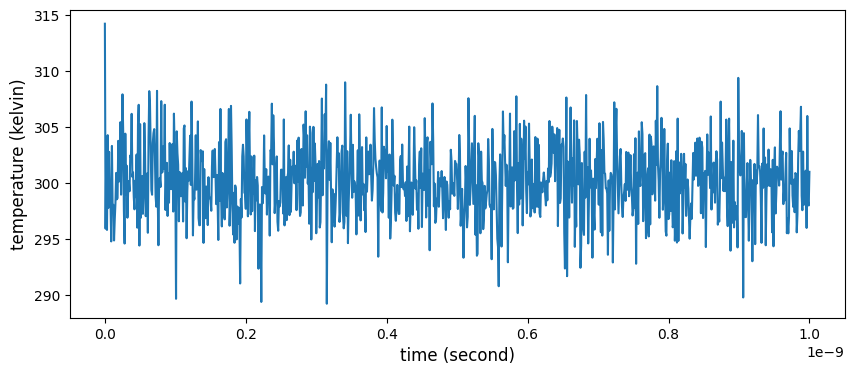

In [8]:
fig = plt.figure(figsize=(10,4))
section_calculation = archive.run[-1].calculation  ## FIND THE SECTION CALCULATION IN THE ARCHIVE ##   
temperature_unit = section_calculation[0].temperature.units  ## FIND THE UNIT OF TEMPERATURE USED IN THE ARCHIVE ##    
time_unit = section_calculation[0].time.units  ## FIND THE UNIT OF TIME USED IN THE ARCHIVE ##

temperature, time = [], []
for calc in section_calculation:
    temperature.append(calc.temperature.magnitude)  ## FIND THE TEMPERATURE FOR THIS CALC ##
    time.append(calc.time.magnitude)  ## FIND THE TIME FOR THIS CALC ##


plt.plot(time, temperature)
plt.ylabel(f"temperature ({temperature_unit})", fontsize=12)
plt.xlabel(f"time ({time_unit})", fontsize=12)
plt.show()

As you may have noticed, one of our bottlenecks in visualizing the trajectory is downloading the data. This is due to the archive's size (35.8 MB, not too uncommon with MD entries). Considering how the task at hand is quite specific, would it not be great if we could just download the parts we need? This is exactly the purpose of the `/query` endpoint. Go back to the [API dashboard](https://nomad-lab.eu/prod/v1/staging/api/v1/extensions/docs#/entries%2Farchive/post_entry_archive_query_entries__entry_id__archive_query_post) and check out its schema.


This endpoint uses `post`, which is either used to add data (such as under `uploads`) or more complex queries and additional parameters, i.e. a more customizable `get` statement. This is in line with the standard semantics in HTTPS messages. In the case of our `/query` endpoint, the parameter we are looking for is `required` -the sections / quantities to be downloaded. Their specification follows the archive's tree structure as a nested dictionary. `requests` can append this information to the HTTPS body using the `json` argument. Below you will find the query specification. Pay attention to the optional use of indexes. 

In [9]:
query_specification = {
    "required": {
        "run[0]": {
            "calculation": {
                "temperature": "*",
                "time": "*"
            }
        }
    }
}

In [10]:
nomad_url_filtered = nomad_individual_archive_url('hxaepf6x12Xt2IX2jCt4DyfLG0P4', endpoint_type='query')
response_filtered = measure_method(requests.post, nomad_url_filtered, json=query_specification)
data_filtered = response_filtered.json()

Method took 0 minutes and 0 seconds to execute.


Note the difference in time! There is a noticeable speedup.

The only disadvantage is that `EntryArchive` will fail with a partial archive. We can use still use the data as we would any dictionary, but we also use unit conversions. To reintroduce units, multiply the quantity with its corresponding `ureg` unit, e.g. `ureg.second`. The quantities, as downloaded, are SI by default.

Take some time to search through the calculation section to see what other quantities are stored there for this simulation...

Now let's plot the water-water center of mass rdf averaged over the last 80% of the trajectory, similar to what was displayed on the overview page in Tutorial 2: 

In [11]:
archive.workflow2.results

MolecularDynamicsResults(calculation_result_ref, calculations_ref, temperature, trajectory, radial_distribution_functions)

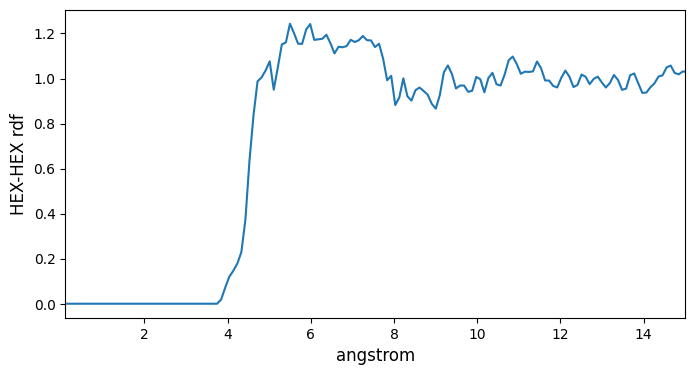

In [12]:
fig = plt.figure(figsize=(8,4))
section_MD = archive.workflow2  ## FIND THE MOLECULAR DYNAMICS WORKFLOW SECTION IN THE ARCHIVE ##
rdf_SOL_SOL = section_MD.results.radial_distribution_functions[0].radial_distribution_function_values[-1]  ## FIND THE LAST SOL-SOL RDF STORED IN THE ARCHIVE ##
rdf_start = rdf_SOL_SOL.frame_start  ## FIND THE STARTING FRAME FOR AVERAGING FOR THIS RDF ##
rdf_end = rdf_SOL_SOL.frame_end  ## FIND THE ENDING FRAME FOR AVERAGING FOR THIS RDF ##

bins = ureg.convert(rdf_SOL_SOL.bins.magnitude, rdf_SOL_SOL.bins.units, ureg.angstrom)  

plt.plot(bins, rdf_SOL_SOL.value)
plt.xlabel(ureg.angstrom, fontsize=12)
plt.ylabel('HEX-HEX rdf', fontsize=12)
plt.xlim(0.1,15.0)
plt.show()

The NOMAD archive format support conversion to a number of handy MD trajectory format that come with their own set of analysis tools.
Here, we will take a look at the *MDAnalysis* format:

In [13]:
# should take ~10 s
universe = archive_to_universe(archive)

Let's use this format to examine the protein simulation in more detail. First, let's check which molecule type are present:

In [14]:
print('Molecule Types')
print('--------------')
for moltype in np.unique(universe.atoms.moltypes): 
    print(moltype)

Molecule Types
--------------
HEX


Let's get acquainted with the *MDAnalysis* software by reproducing the water-water molecular rdf that we plotted above.

In [15]:
# Get an atom group for the water
AG_SOL = universe.select_atoms('moltype HEX')

# Create a "bead group" for the water.
# In MDAnalysis, it is not trivial to calculate center of mass rdfs. 
# The concept of bead groups comes from a known work-around. 
# This class is imported from the NOMAD software. 
BG_SOL = BeadGroup(AG_SOL, compound="fragments")


min_box_dimension = np.min(universe.trajectory[0].dimensions[:3])
max_rdf_dist = min_box_dimension / 2
n_bins = 200
n_smooth = 2
n_prune = 1

In [16]:
# should take ~2 min
exclusion_block = (1, 1)  # for removing self-distance
rdf = MDA_RDF.InterRDF(
    BG_SOL, BG_SOL, range=(0, max_rdf_dist),
    exclusion_block=exclusion_block, nbins=n_bins).run(
    rdf_start, rdf_end, n_prune)

In [17]:
# smooth the rdf
rdf.results.bins = rdf.results.bins[int(n_smooth / 2):-int(n_smooth / 2)]
rdf.results.rdf = np.convolve(
    rdf.results.rdf, np.ones((n_smooth,)) / n_smooth,
    mode='same')[int(n_smooth / 2):-int(n_smooth / 2)]

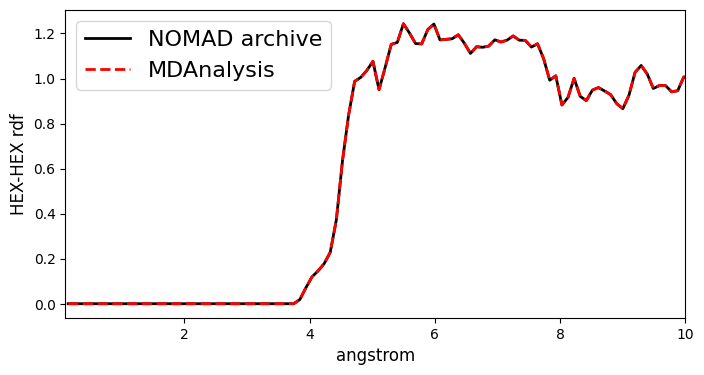

In [18]:
fig = plt.figure(figsize=(8,4))
plt.plot(bins, rdf_SOL_SOL.value, label='NOMAD archive', color='k', lw=2)
plt.plot(rdf.results.bins, rdf.results.rdf, label='MDAnalysis', linestyle='--', color='r', lw=2)

plt.legend(fontsize=16)
plt.xlabel(ureg.angstrom, fontsize=12)
plt.ylabel('HEX-HEX rdf', fontsize=12)
plt.xlim(0.1, 10.)
plt.show()

Using MDAnalysis, we can easily featurize the system for ML analysis

In [19]:
carbon_indices = [ind for ind, type in enumerate(universe.atoms.types) if type.startswith('C')]
selection = 'index ' + ' '.join([str(ind) for ind in carbon_indices])
carbons_group = universe.select_atoms(f'{selection}')

In [20]:
for i_fr, frame in enumerate(universe.trajectory):
    if i_fr == 0:
        distances = self_distance_array(carbons_group.positions, box=frame._unitcell)
    else:
        distances = np.vstack((distances, self_distance_array(carbons_group.positions, box=frame._unitcell)))

In [21]:
distances.shape

(11, 1282401)

We can visualize the system with NGLViewer

In [22]:
import MDAnalysis as MDA
path = '/home/jfrudzinski/work/GRO_DEV/MD_Overview/Hexane/Hexane_trimmed/'
sys = 'hexane.267'
tpr_fnm = sys+'.tpr'
trr_fnm = sys+'.trr'
universe = MDA.Universe(path + tpr_fnm, path + trr_fnm)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jfrudzinski/work/GRO_DEV/MD_Overview/Hexane/Hexane_trimmed/hexane.267.tpr'

In [ ]:
# select all atoms except for virtual sites associated with the water model
# should take ~15 s
AG_all = universe.select_atoms('all')
for ts in universe.trajectory:  # make the molecules whole 
    AG_all.unwrap(compound='fragments')

In [ ]:
# Set up the viewer
view = nv.show_mdanalysis(AG_all)
view.center()
view.clear()  # clear the initial representation automatically set up by nglview
view.add_point('all')  # employ lightest rep
# adjust the widget size
view._set_size('700px', '600px')


view

NGLWidget(count=11)

You can adjust the visualization using nglview selection commands https://nglviewer.org/ngl/api/manual/usage/selection-language.html 

In [ ]:
moltype = 'HEX'  
view.clear()
view.add_point('all')
# view.add_ball_and_stick(moltype)
view.add_spacefill('atom name .C')


In [ ]:
moltype = 'HEX'  
view.clear()
view.add_point('all')
# view.add_ball_and_stick(moltype)
selection = '@' + ', '.join([str(i) for i in universe.select_atoms('molnum 0')._ix])
view.add_spacefill(selection)

## Exercise

Up until now, we have worked exclusively with the data contained in a single archive. While NOMAD workflows allow for comparison between its entries, you can fully customize your analysis locally.

Remember how we bookmarked our settings at the end of scenario 1 in [part I](part1.md)? **Restore the settings of that page.** If you did not bookmark the exercise, or cannot find it anymore, click [this link](https://nomad-lab.eu/prod/v1/staging/gui/search/entries?program_name=GROMACS&upload_create_time[gte]=1419895487748&upload_create_time[lte]=1694679900000&exclusive=true&elements=O&elements=H) to return to the solution. We had here 2 authors with 2 MD simulations of water, each. Let us try and compare their setups and results.

First, however, constrain the search to **exclude the geometry optimizations**, by requiring `workflow.molecular_dynamics.with_trajecotry`. You can find the filters under side menu > "Visbility / IDs / Schema" > "Metainfo definition" or use a presence query in the search bar.

Similar to the first exercise, we will again use the `post` HTTPS method with a query in JSON format. Since we are now searching through the whole database, we do not need just a `required` section anymore, but also a `query` for selecting the appropriate entries. NOMAD provides an easy way to convert your chosen filters into a query. On the entries list, locate the filters side menu. Right from "FILTERS", you will find a code icon (`<>`).

Clicking it opens an API overview with 3 JSON bundles displayed, in descending order they stand for:

1. the active filters.
2. the full API command used to display the page.
3. the response returned by server to the previous API call (here the JSON format is displayed in a different style).

**Option 1** suffices, for our intents and purposes, so **copy it over** via the clipboard symbol.

That handles `owner` (the access rights) and `query`. Now, **extend the query with `required`.** In this case, we will be comparing **`velocities`** under `run`. We will also be needing the **`metadata`**.
Tip: use the [Metainfo Browser](https://nomad-lab.eu/prod/v1/staging/gui/analyze/metainfo/nomad.datamodel.datamodel.EntryArchive) to retrieve the path.

In [114]:
# success
query_specification = {
    "owner": "visible",
    "query": {
        "results.method.simulation.program_name:any": [
        "GROMACS"
        ],
        "upload_create_time": {
        "gte": 1419895487748,
        "lte": 1694679900000
        },
        "quantities:all": [
        "workflow.molecular_dynamics.with_trajectory"
        ],
        "results.material.elements_exclusive": "H O"
    },
    "pagination": {
        "page_size": 10
    },
    "required": {
        "run": {
            "system": {
                "atoms": {
                    "velocities": "*"
                }
            }
        },
        "metadata": "*"
    }
}

**Info:** in the solution above, you will find one additional keyword: `pagination`. This controls the amount data downloaded at a time. When the number of hits exceeds the `page_size`, you will links to scroll back and forth between pages. This comes especially in handy when downloading large datasets.

Once you have the query set, perform the API call to download the data. Note that the endpoint to use is different this time: `entries/archive/query`. Write the results out to `response_entries` and `data_entries`.

In [115]:
# success
nomad_entries_url = 'https://nomad-lab.eu/prod/v1/staging/api/v1/entries/archive/query'
response_entries = measure_method(requests.post, nomad_entries_url, json=query_specification)
data_entries = response_entries.json()
print(response_entries)

Method took 0 minutes and 4 seconds to execute.
<Response [200]>


Let us check whether we downloaded all of the entries.

In [116]:
len(data_entries['data'])

4

Then, we group the velocities by author, extract the vector lengths and convert them to appropriate units. This is obviously under the presumption that both authors split their trajectories in 2, but maintained the same conditions.

In [144]:
velocities = {}

for data in data_entries['data'][1:]:
    author_key = data['archive']['metadata']['main_author']

    if author_key not in velocities:
        velocities[author_key] = []

    for system in data['archive']['run'][0]['system']:
        velocities[author_key] += system['atoms']['velocities']

for author_key, vectors in velocities.items():
    magnitudes = np.linalg.norm(np.array(vectors), axis=1) # extract only the vector lengths
    velocities[author_key] = ureg.convert(magnitudes, ureg.meter_per_second, ureg.angstrom / ureg.picosecond) # convert to angstrom / picosecond

len(velocities)

2

Finally, plot them out as histograms comparing the velocity distribution.

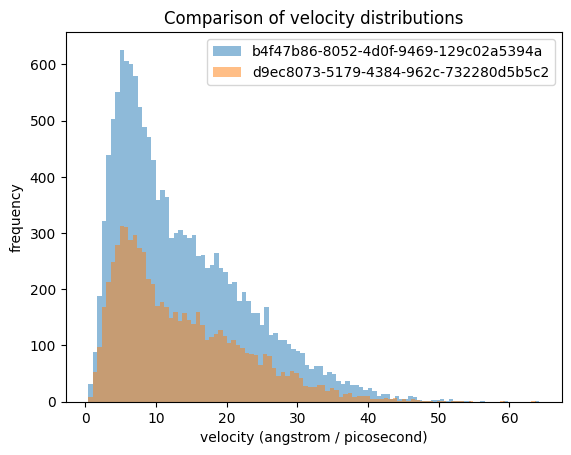

In [146]:
## success
# Create histograms
alpha = .5
bins = 100
plt.hist(list(velocities.values())[0], bins=bins, alpha=alpha, label=f'{list(velocities.keys())[0]}')
plt.hist(list(velocities.values())[1], bins=bins, alpha=alpha, label=f'{list(velocities.keys())[1]}')

# Add title, labels, and legend
plt.title(f'Comparison of velocity distributions')
plt.xlabel('velocity (angstrom / picosecond)')
plt.ylabel('frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

**success:**
Both distributions clearly follow Boltzmann, indicating that they are thermally equilibrated. Both seem to have run at more or less the same temperature (approximately 290 K, based on [Sebastian Baumgart's entries](https://nomad-lab.eu/prod/v1/staging/gui/search/entries/entry/id/4tVpRNvoGHXvkBMT23U3gD-LjsVF)). The system in blue either ran for much more time, or on a larger system, generating more velocities. Based on [Jannik Mehlis' entries](https://nomad-lab.eu/prod/v1/staging/gui/search/entries/entry/id/onZ-VgGl21sem_kvlR7sj8dpR4bf), it is likely the system size.